In [26]:
import pandas
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sigmaclip, t
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, Lars, BayesianRidge, TweedieRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from functions import *

WEAK_CORR = 0.25
STRONG_CORR = 0.7

warnings.filterwarnings('ignore')

Чтение файла, поиск NaN значений

In [2]:
frame = pandas.read_csv("train.csv")
frame = frame.drop(columns='id')
columns = [column for column in frame]
input_columns = columns[1:-1]
output_column = columns[-1]
numeric = ['Количество.комнат', 'Общая.площадь', 'Этаж', 'Этажей.в.доме', 'Год.постройки', 'Школа.1000', 'ВУЗ.1000', 'ТЦ.1000', 'Стоматология.1000', 'Почта.1000', 'Поликлиника.1000', 'Парк.1000', 'Остановка.1000', 'Одежда..1000', 'Супер3кет.1000', 'Кинотеатр.1000', 'Кафе.1000', 'АЗС.1000', 'Детский.сад.1000', 'Бар.1000', 'Банк.1000', 'Аптека.1000', 'Цена']
print(frame.isna().sum())

Количество.комнат            0
Студия                       0
Общая.площадь                0
Этаж                         0
Этажей.в.доме                0
Парковка                     0
Без.ремонта                  0
Дизайнерский                 0
Евроремонт                   0
Косметический                0
Балкон                       0
Лоджия                       0
Совмещенный.санузел          0
Раздельный.санузел           0
Лифт                         0
Грузовой.лифт                0
Мусоропровод                 0
Год.постройки                0
Аварийный                    0
Железобетонные.перекрытия    0
Смешанные.перекрытия         0
Деревянные.перекрытия        0
Иные.перекрытия              0
Панельные.стены              0
Блочные.стены                0
Деревянные.стены             0
Кирпичные.стены              0
Монолитные.стены             0
Смешанные.стены              0
Школа.1000                   0
ВУЗ.1000                     0
ТЦ.1000                      0
Стоматол

In [3]:
corr_df = frame.corr()
corr_df = corr_df.sort_values(by = 'Цена', key=lambda x: abs(x))

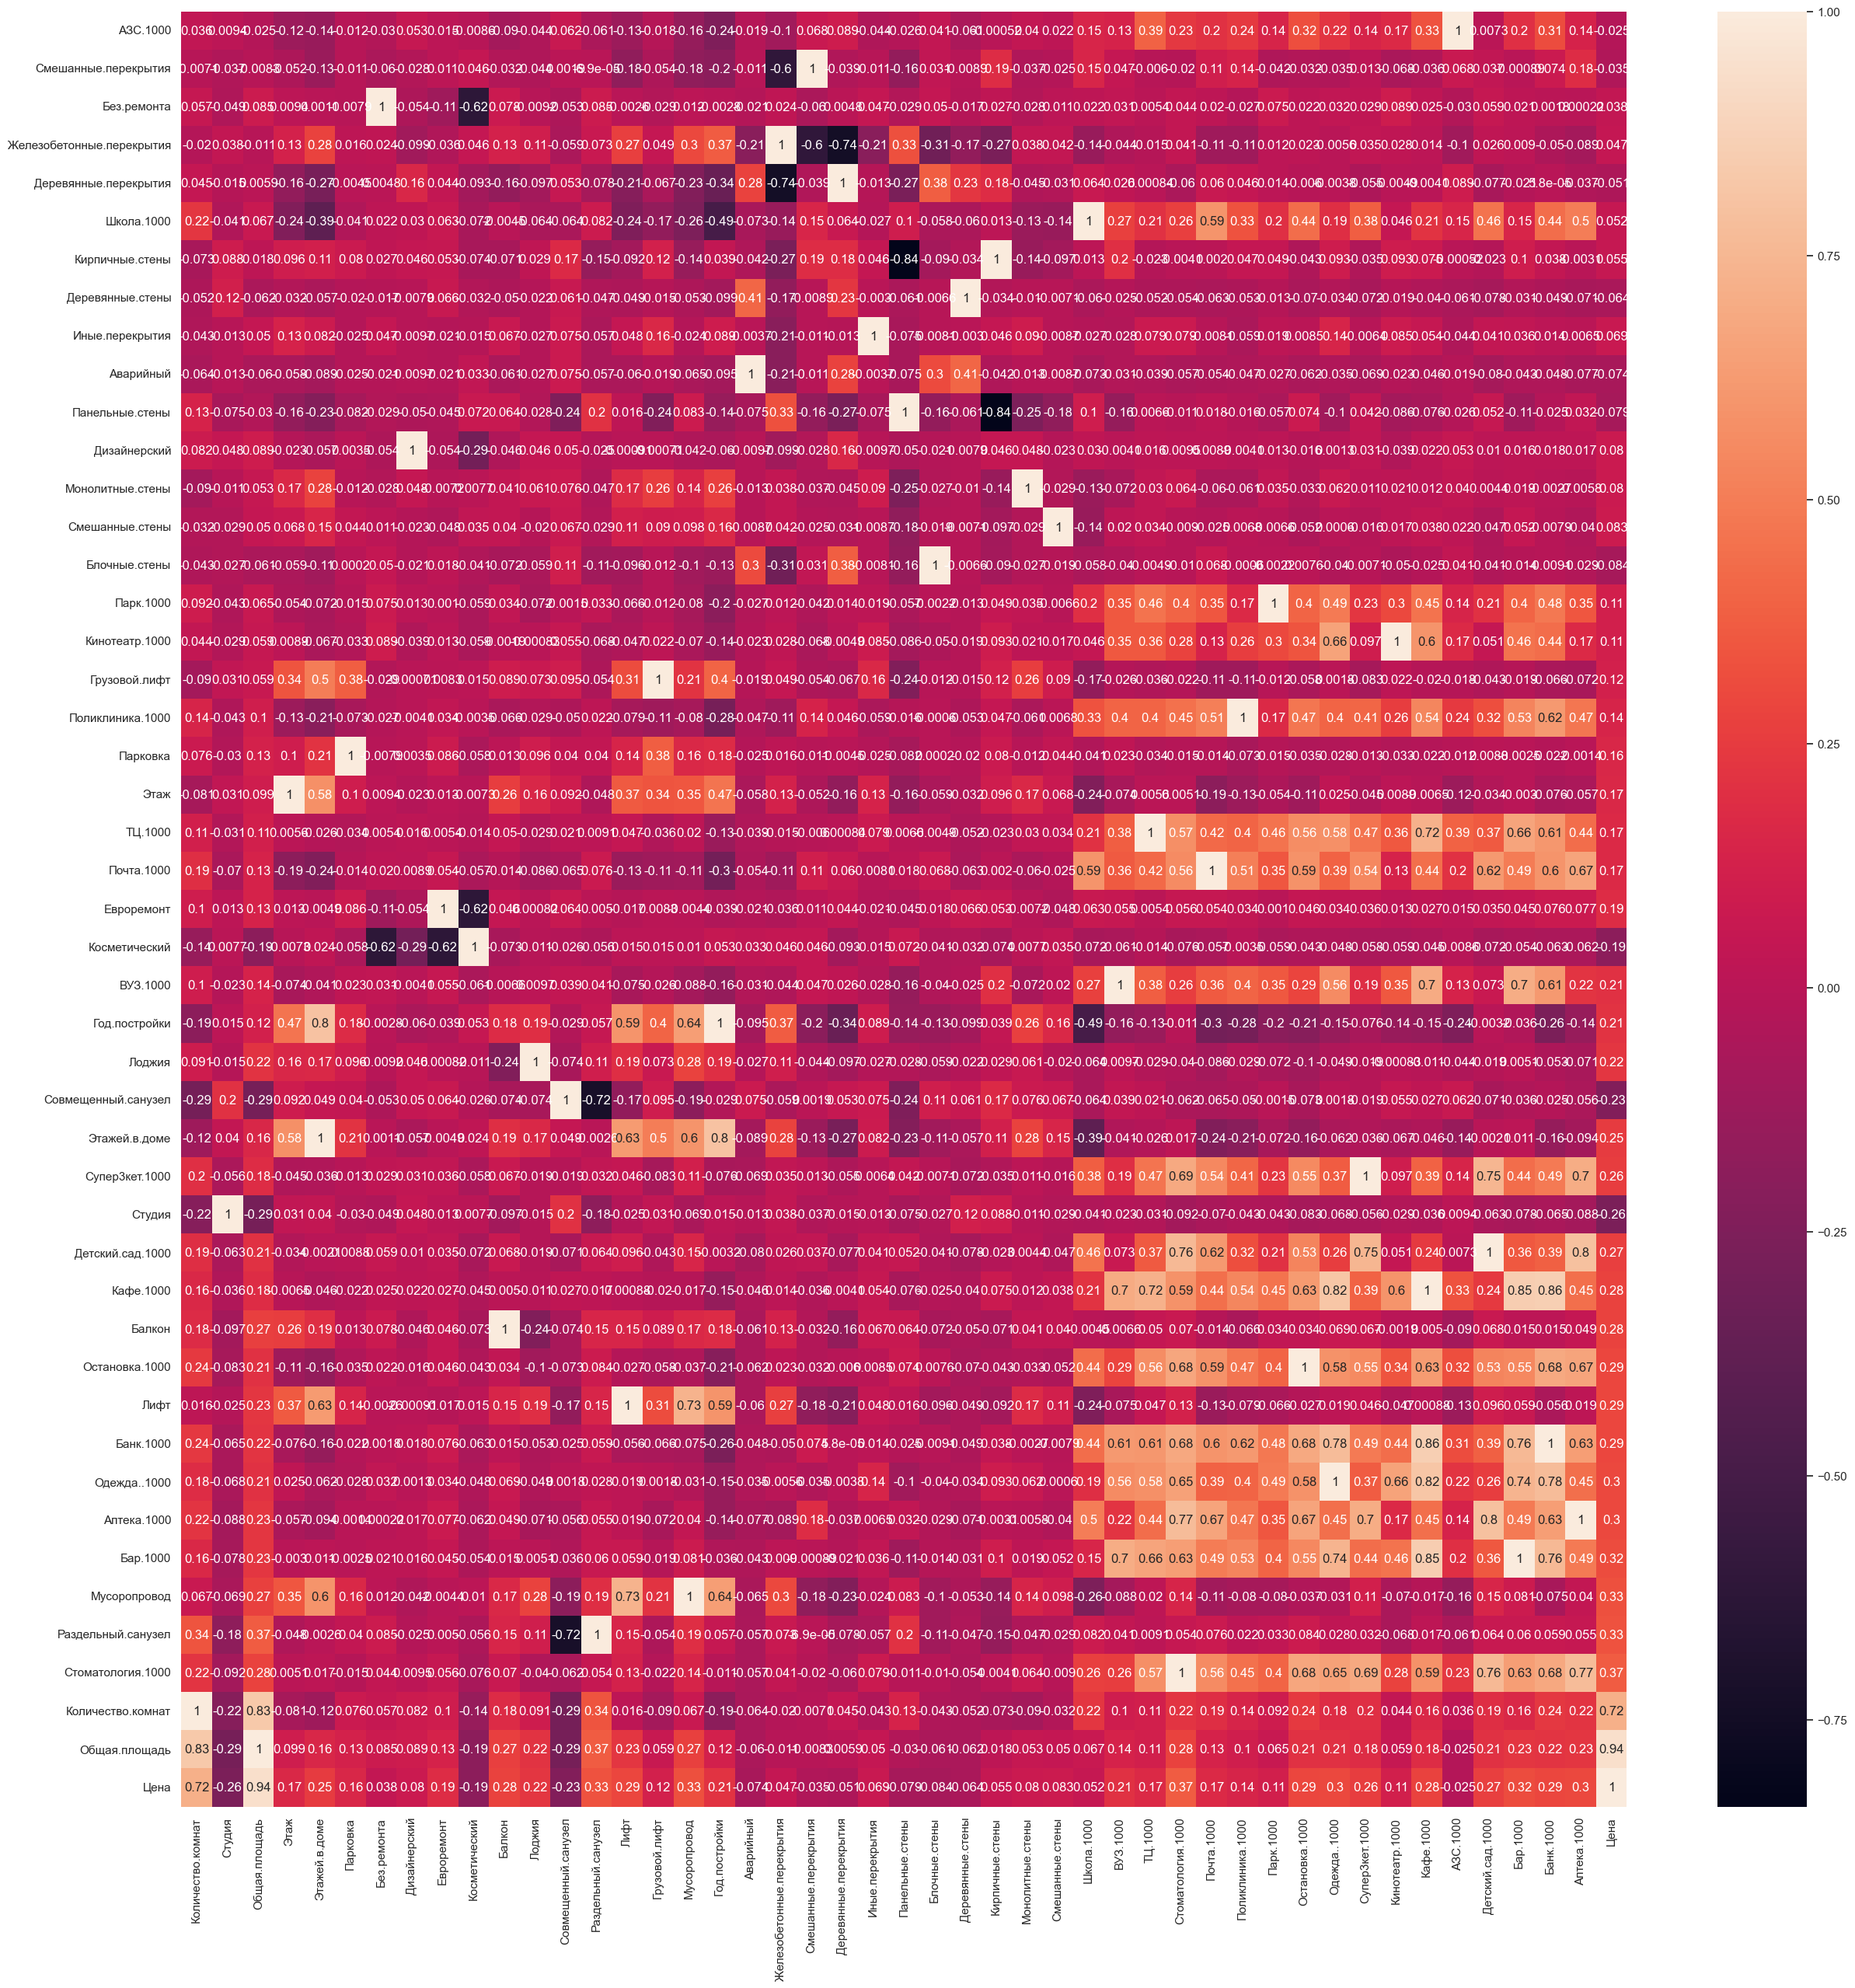

In [4]:
create_heatmap(corr_df)

Удаление слабо коррелирующих столбцов

In [5]:
columns = []
for i, x in zip(corr_df.index, corr_df['Цена']):
    if x >= WEAK_CORR:
        columns.append(i)
frame = frame[columns]
print(f"Оставшиеся столбцы - {columns}")
corr_df = frame.corr()

Оставшиеся столбцы - ['Этажей.в.доме', 'Супер3кет.1000', 'Детский.сад.1000', 'Кафе.1000', 'Балкон', 'Остановка.1000', 'Лифт', 'Банк.1000', 'Одежда..1000', 'Аптека.1000', 'Бар.1000', 'Мусоропровод', 'Раздельный.санузел', 'Стоматология.1000', 'Количество.комнат', 'Общая.площадь', 'Цена']


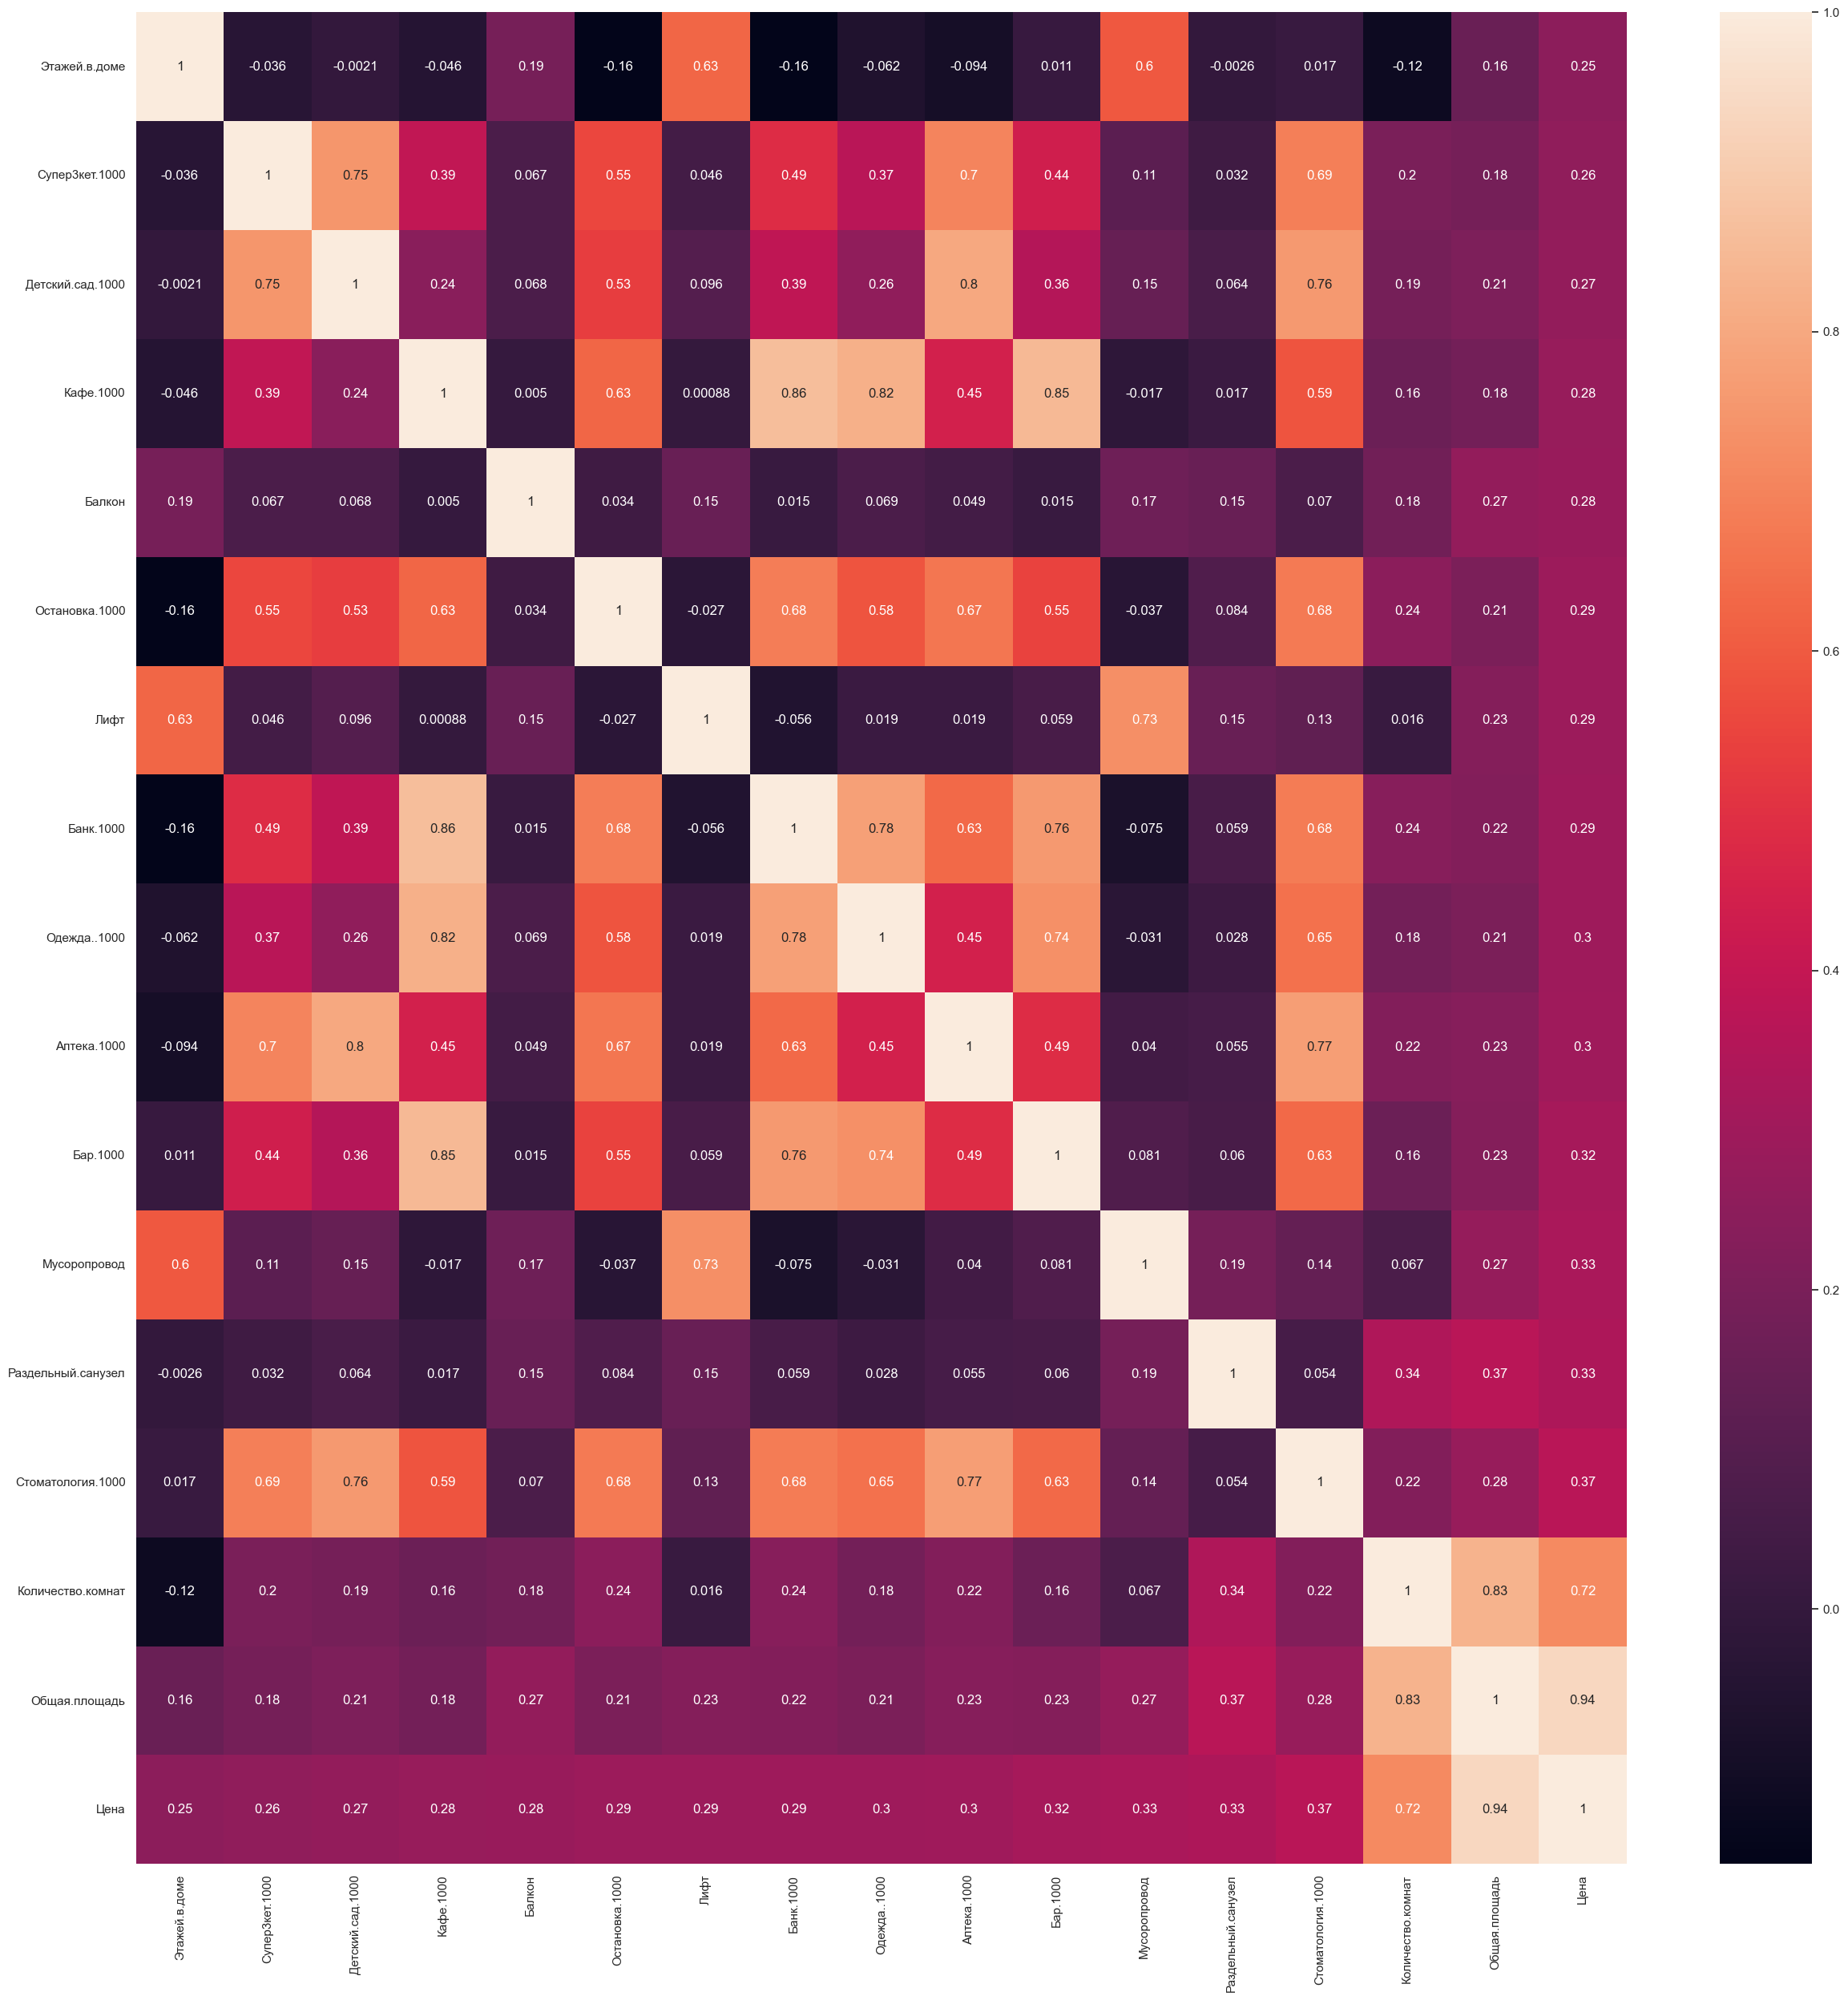

In [6]:
create_heatmap(corr_df)

Удаление сильно коррелирующих друг с другом значений

In [7]:
removed = set()
for row in corr_df.iterrows():
    row = row[0]
    for column in corr_df.columns:
        if STRONG_CORR <= corr_df[row][column] < 1:
            removed.add(max([row, column], key=lambda x: abs(corr_df[x]['Цена'])))
            #removed.add(max(abs(corr_df[row]['Цена']), abs(corr_df[column]['Цена'])))
print(removed)
corr_df = corr_df.drop(index=removed,  columns=removed)
corr_df

{'Аптека.1000', 'Общая.площадь', 'Стоматология.1000', 'Одежда..1000', 'Бар.1000', 'Детский.сад.1000', 'Мусоропровод', 'Банк.1000', 'Цена'}


,Этажей.в.доме,Супер3кет.1000,Кафе.1000,Балкон,Остановка.1000,Лифт,Раздельный.санузел,Количество.комнат
Этажей.в.доме,1.000000,-0.036335,-0.046274,0.193552,-0.159559,0.625279,-0.002560,-0.120341
Супер3кет.1000,-0.036335,1.000000,0.392901,0.067278,0.552060,0.046130,0.032170,0.200743
Кафе.1000,-0.046274,0.392901,1.000000,0.005024,0.625532,0.000879,0.017267,0.160463
Балкон,0.193552,0.067278,0.005024,1.000000,0.033501,0.149445,0.150856,0.175734
Остановка.1000,-0.159559,0.552060,0.625532,0.033501,1.000000,-0.026830,0.084051,0.244324
Лифт,0.625279,0.046130,0.000879,0.149445,-0.026830,1.000000,0.151355,0.016063
Раздельный.санузел,-0.002560,0.032170,0.017267,0.150856,0.084051,0.151355,1.000000,0.341588
Количество.комнат,-0.120341,0.200743,0.160463,0.175734,0.244324,0.016063,0.341588,1.000000


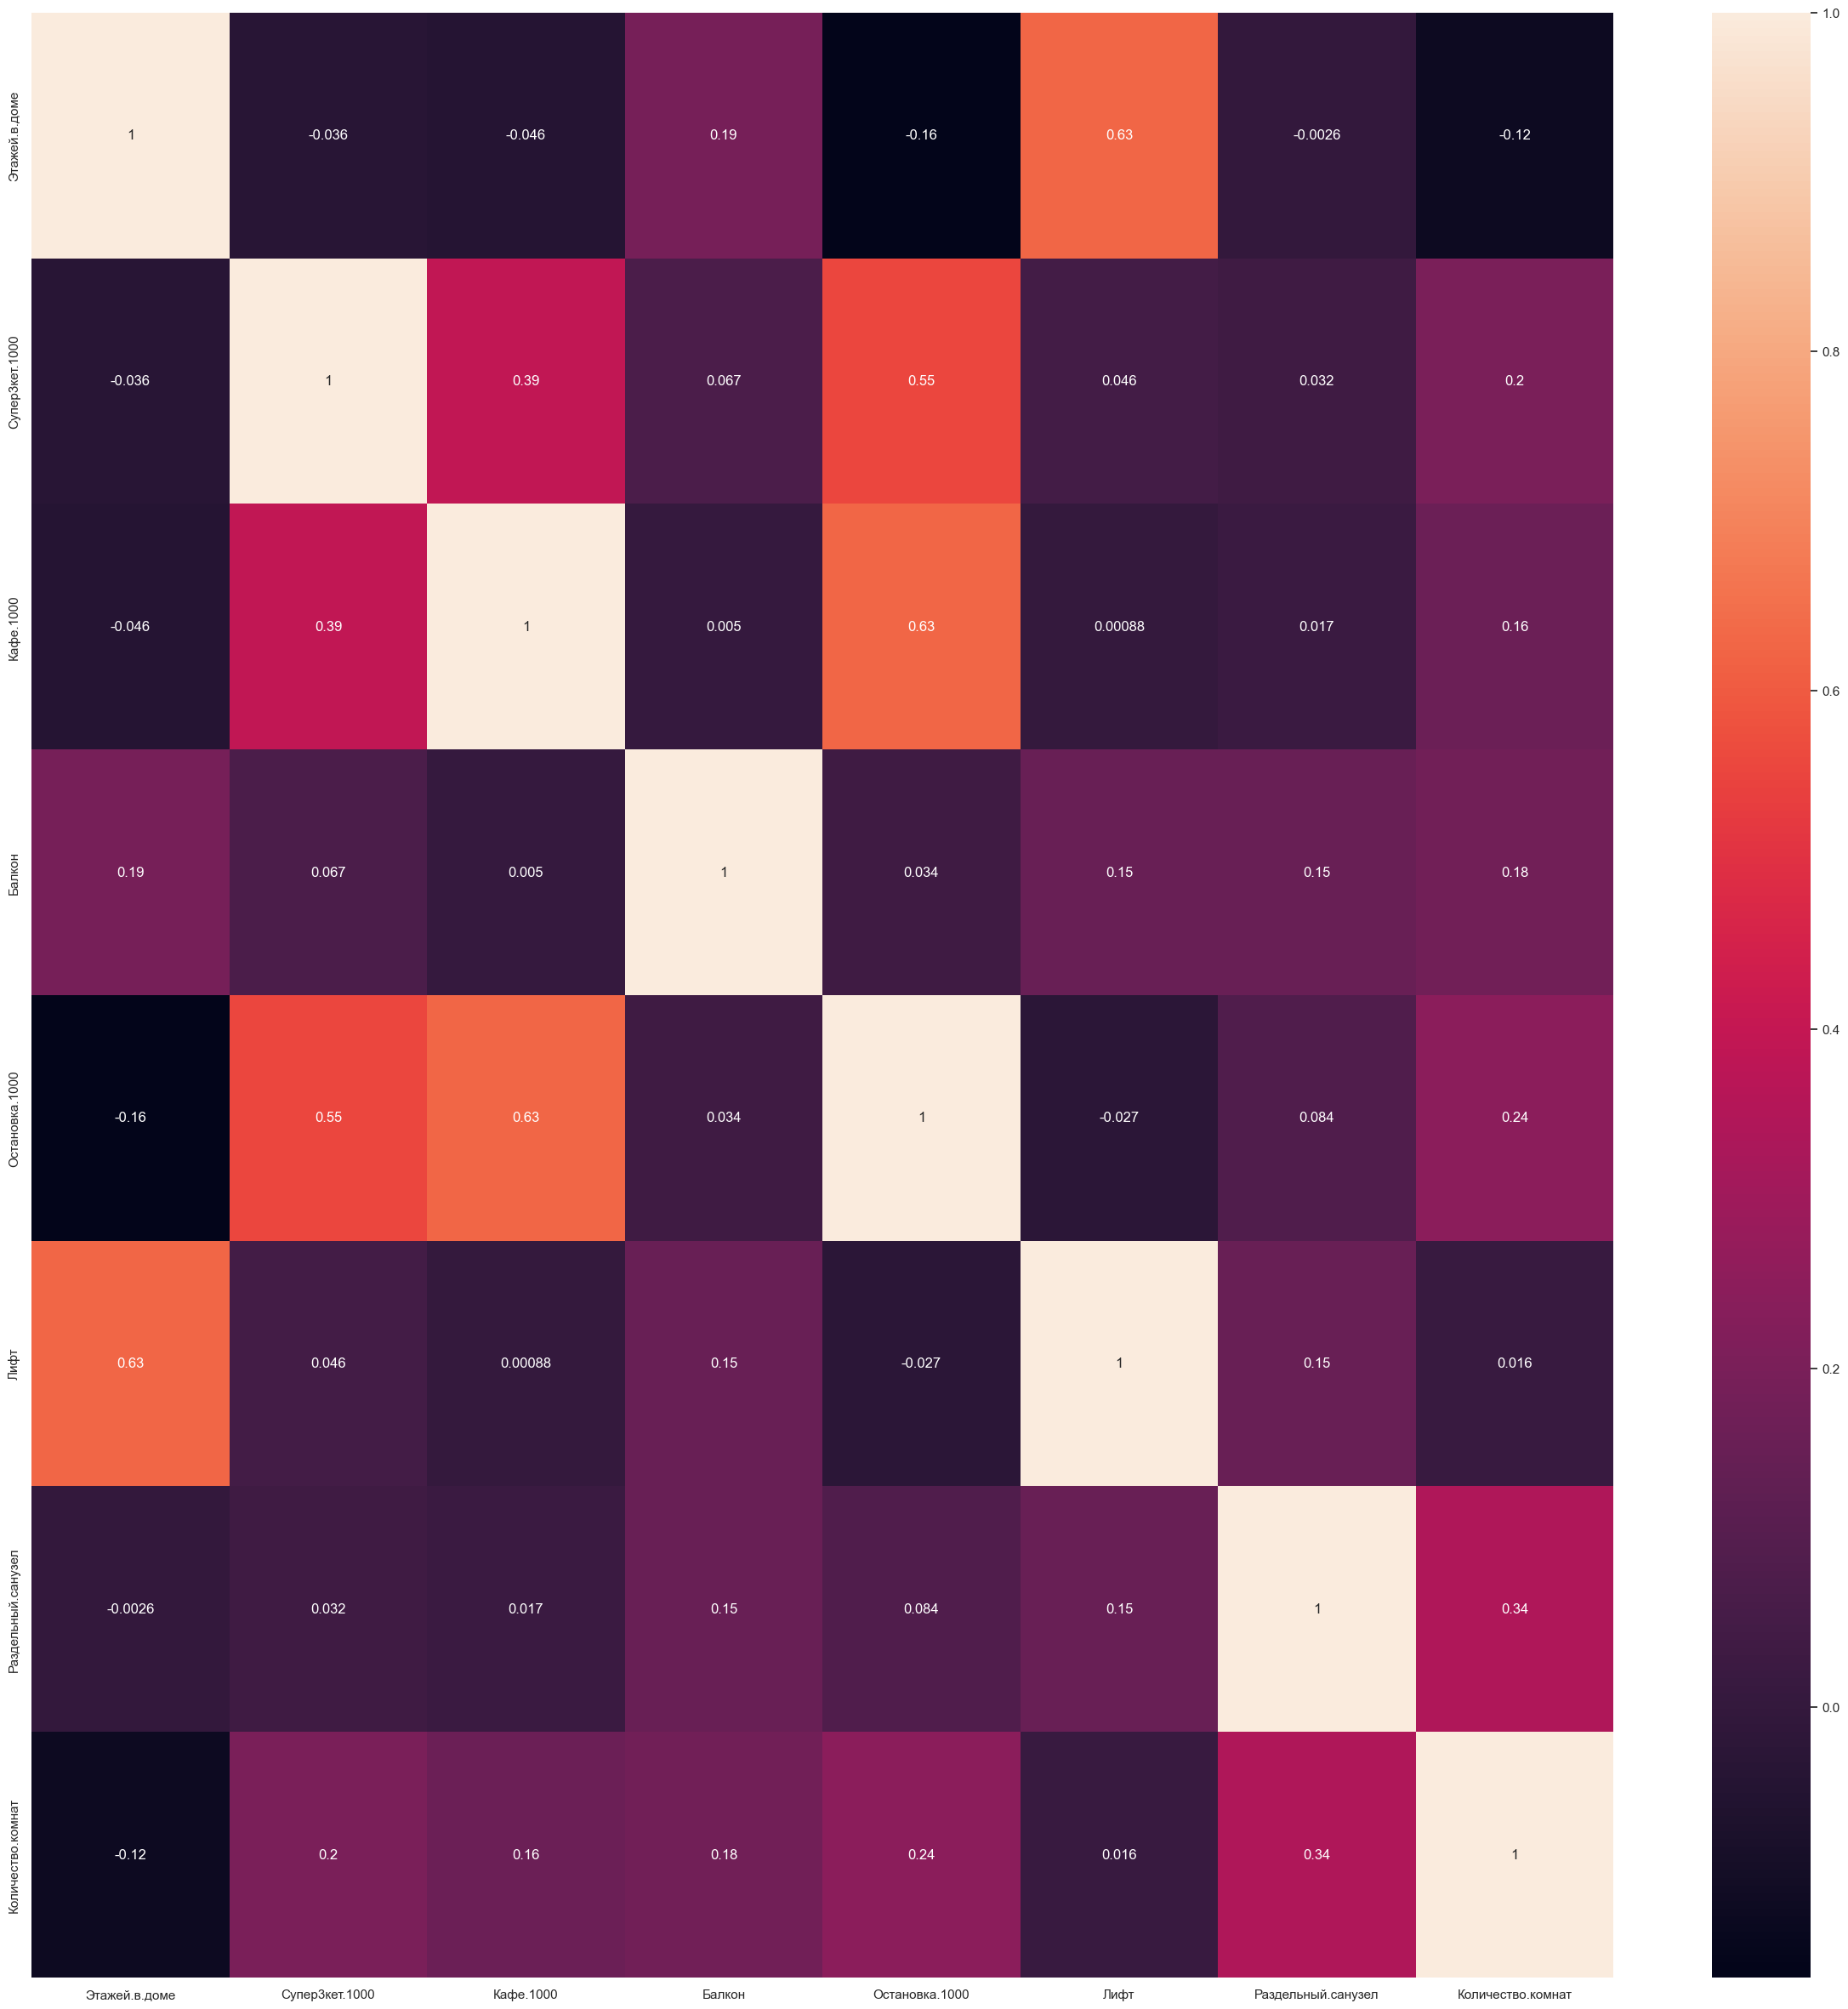

In [8]:
create_heatmap(corr_df)


In [9]:
# Вручную удаляем лишние столбцы

input_columns = columns[:-1]
frame = frame[columns]
print(columns)

['Этажей.в.доме', 'Супер3кет.1000', 'Детский.сад.1000', 'Кафе.1000', 'Балкон', 'Остановка.1000', 'Лифт', 'Банк.1000', 'Одежда..1000', 'Аптека.1000', 'Бар.1000', 'Мусоропровод', 'Раздельный.санузел', 'Стоматология.1000', 'Количество.комнат', 'Общая.площадь', 'Цена']


# Нормализация
frame[input_columns] = MinMaxScaler().fit_transform(frame[input_columns])
print(frame)

In [10]:
# Удаление аномальных значений
print(f"Количество строк в исходной таблице = {len(frame)}")
for x in numeric:
    if x in frame:
        frame = sigma_clip(frame, x)
print(f"Количество строк в таблице после удаления аномальных значений - {len(frame)}")

Количество строк в исходной таблице = 808
Количество строк в таблице после удаления аномальных значений - 721


In [11]:
# Делим выборку на тренировочную и тестовую
X, Y = frame[input_columns], frame[output_column]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=0)
regressions = []
RMSE = {}

Отбор признаков для моделей без регу

In [29]:
kbest = SelectKBest(k=5, score_func=chi2)
kbest_frame = kbest.fit_transform(frame[input_columns], frame[output_column])
kbest_columns = list(kbest.get_feature_names_out())

kbest_columns

['Детский.сад.1000',
 'Одежда..1000',
 'Аптека.1000',
 'Стоматология.1000',
 'Общая.площадь']

In [ ]:
# Делим выборку на тренировочную и тестовую с отобранными признаками

Линейная регрессия

In [32]:
parameters = {'n_jobs': range(1, 11)}
grid = GridSearchCV(LinearRegression(), parameters)
#reg = LinearRegression(copy_X = True).fit(x_train, y_train)
reg = grid.fit(x_train[kbest_columns], y_train).best_estimator_
regressions.append(reg)
print(coef_stats(reg, x_test[kbest_columns], y_test, lib="scl"))
stats = get_model_stats(reg, x_test[kbest_columns], y_test)
print(stats)
RMSE["Линейная регрессия"] = stats["RMSE"]

                Name    t-value   p-value  Is valuable  \
0   Детский.сад.1000  -0.278914  0.780583        False   
1       Одежда..1000  -1.339728  0.181768        False   
2        Аптека.1000   1.135421  0.257481        False   
3  Стоматология.1000   1.810897  0.071572        False   
4      Общая.площадь  51.652080  0.000000         True   

                     95% Confidence Interval  
0   [-14279.12445947209, 10154.135241499045]  
1  [-15864.509200081595, 1656.2581489217064]  
2   [-2954.249866738148, 15939.092663947755]  
3    [1628.1821045608922, 35500.67697447821]  
4    [46326.241980983665, 49387.61474471349]  
R^2             0.868407
Adj r^2         0.865289
RMSE       381234.037469
AIC          5587.407232
BIC          5604.306719
dtype: float64


Lasso

In [23]:
parameters = {'alpha': range(1, 10)}
grid = GridSearchCV(Lasso(), parameters)
reg = grid.fit(x_train[kbest_columns], y_train).best_estimator_
regressions.append(reg)
coef_stats(reg, x_test[kbest_columns], y_test, lib="scl")
stats = get_model_stats(reg, x_test[kbest_columns], y_test)
print(coef_stats(reg, x_test[kbest_columns], y_test, lib="scl"))

print(stats)
RMSE["Lasso"] = stats["RMSE"]

                  Name    t-value   p-value  Is valuable  \
0        Этажей.в.доме   2.722004  0.007059         True   
1       Супер3кет.1000   0.677958  0.498578        False   
2     Детский.сад.1000  -0.955527  0.340459        False   
3            Кафе.1000   0.585853  0.558631        False   
4               Балкон   0.329596  0.742048        False   
5       Остановка.1000   1.800758  0.073240        False   
6                 Лифт   0.014131  0.988739        False   
7            Банк.1000   0.783717  0.434129        False   
8         Одежда..1000  -0.944523  0.346036        False   
9          Аптека.1000   0.295474  0.767937        False   
10            Бар.1000   1.559759  0.120390        False   
11        Мусоропровод   0.366681  0.714243        False   
12  Раздельный.санузел   0.648262  0.517556        False   
13   Стоматология.1000   0.277198  0.781913        False   
14   Количество.комнат  -3.017363  0.002880         True   
15       Общая.площадь  23.231529  0.000

Ridge

In [14]:
parameters = {'alpha': range(1, 10), 'solver': ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]}
grid = GridSearchCV(Ridge(), parameters)
reg = grid.fit(x_train, y_train).best_estimator_
regressions.append(reg)
print(cross_validate(reg, x_test, y_test)['test_score'])
print(coef_stats(reg, x_test, y_test, lib="scl"))
stats = get_model_stats(reg, x_test, y_test)
print(stats)
RMSE["Ridge"] = stats["RMSE"]

[0.89468278 0.9087805  0.87955026 0.91103068 0.88970124]
R^2             0.901133
Adj r^2         0.893224
RMSE       330445.786551
AIC          5547.357884
BIC          5601.436242
dtype: float64


Elastic-Net

In [15]:
parameters = {'alpha': range(1, 10), "l1_ratio": [x/10 for x in range(1, 10)]}
grid = GridSearchCV(ElasticNet(), parameters)
reg = grid.fit(x_train, y_train).best_estimator_
regressions.append(reg)
print(cross_validate(reg, x_test, y_test)['test_score'])
print(coef_stats(reg, x_test, y_test, lib="scl"))
stats = get_model_stats(reg, x_test, y_test)
print(stats)
RMSE["Elastic-Net"] = stats["RMSE"]

[0.89453508 0.91081888 0.88144292 0.91033473 0.89072651]
R^2             0.900467
Adj r^2         0.892505
RMSE       331557.352337
AIC          5548.815340
BIC          5602.893697
dtype: float64


Метод наименьших углов

In [64]:
reg = Lars(copy_X = True).fit(x_train, y_train)
regressions.append(reg)
print(cross_validate(reg, x_test, y_test)['test_score'])
print(coef_stats(reg, x_test, y_test, lib="scl"))
stats = get_model_stats(reg, x_test, y_test)
print(stats)
RMSE["Метод наименьших углов"] = stats["RMSE"]

[0.79245521 0.90097473 0.87629474 0.90419297 0.88793619]
                  Name    t-value   p-value  Is valuable  \
0        Этажей.в.доме   2.851701  0.004803         True   
1       Супер3кет.1000   1.540580  0.124992        False   
2     Детский.сад.1000  -4.250665  0.000033         True   
3            Кафе.1000   0.358285  0.720506        False   
4               Балкон   0.192220  0.847764        False   
5       Остановка.1000   2.107766  0.036291         True   
6                 Лифт  -0.001982  0.998421        False   
7            Банк.1000   1.056296  0.292101        False   
8         Одежда..1000  -1.826602  0.069243        False   
9          Аптека.1000   1.136350  0.257163        False   
10            Бар.1000   1.480709  0.140250        False   
11        Мусоропровод   0.378764  0.705263        False   
12  Раздельный.санузел   0.780336  0.436111        False   
13   Стоматология.1000   2.348631  0.019814         True   
14   Количество.комнат  -2.846638  0.004877

Байесовская регрессия

In [63]:
reg = BayesianRidge(copy_X = True).fit(x_train[kbest_columns], y_train)
regressions.append(reg)
print(cross_validate(reg, x_test[kbest_columns], y_test)['test_score'])
print(coef_stats(reg, x_test[kbest_columns], y_test, lib="scl"))
stats = get_model_stats(reg, x_test[kbest_columns], y_test)
print(stats)
RMSE["Байесовская регрессия"] = stats["RMSE"]

[0.87602059 0.89401341 0.87509399 0.88378803 0.85599198]
                Name    t-value   p-value  Is valuable  \
0   Детский.сад.1000  -0.169189  0.865809        False   
1       Одежда..1000  -1.233844  0.218627        False   
2        Аптека.1000   1.115864  0.265744        False   
3  Стоматология.1000   1.675918  0.095228        False   
4      Общая.площадь  51.702515  0.000000         True   

                    95% Confidence Interval  
0    [-13445.36945416656, 10947.3078675135]  
1  [-15277.62243952922, 2214.0438220739516]  
2  [-3060.9878644245946, 15800.97380255174]  
3    [244.0423302725976, 34060.27674001514]  
4   [46295.94779222675, 49352.235774303634]  
R^2             0.868844
Adj r^2         0.865736
RMSE       380600.827472
AIC          5586.685781
BIC          5603.585268
dtype: float64


Обобщенная линейная регрессия

In [18]:
parameters = {"power": (0, 1, 1.5, 2, 3), "solver": ['lbfgs', 'newton-cholesky']}
grid = GridSearchCV(TweedieRegressor(), parameters)
reg = grid.fit(x_train[kbest_columns], y_train).best_estimator_
regressions.append(reg)
print(cross_validate(reg, x_test[kbest_columns], y_test)['test_score'])
print(coef_stats(reg, x_test[kbest_columns], y_test, lib="scl"))
stats = get_model_stats(reg, x_test[kbest_columns], y_test)
print(stats)
RMSE["Обобщенная линейная регрессия"] = stats["RMSE"]

[0.89440269 0.91521075 0.88775529 0.90945097 0.89177706]
                  Name    t-value   p-value  Is valuable  \
0        Этажей.в.доме   3.486925  0.000600         True   
1       Супер3кет.1000   0.475465  0.634972        False   
2     Детский.сад.1000  -0.656723  0.512110        False   
3            Кафе.1000   0.711480  0.477612        False   
4               Балкон   0.168541  0.866328        False   
5       Остановка.1000   1.368172  0.172786        False   
6                 Лифт   0.071395  0.943155        False   
7            Банк.1000   0.194382  0.846073        False   
8         Одежда..1000  -0.797243  0.426251        False   
9          Аптека.1000   0.679539  0.497578        False   
10            Бар.1000   1.157101  0.248604        False   
11        Мусоропровод   0.090696  0.927824        False   
12  Раздельный.санузел   0.137568  0.890719        False   
13   Стоматология.1000   0.430307  0.667433        False   
14   Количество.комнат  -0.541011  0.589099

Взвешенный МНК

In [34]:
var_type ="".join(["c" if len(X[col].value_counts()) > 2 else "u" for col in X.columns])
#reg = sm.WLS(y_train, x_train, var_type=var_type)
# Обучение с ручной кросс валидацией
skf = StratifiedKFold(n_splits=5)
scores = []
regs = []
for train, test in skf.split(X[kbest_columns], Y):
    train_x, test_x, train_y, test_y = X[kbest_columns].drop(index=test), X[kbest_columns].drop(index=train), Y.drop(index=test), X.drop(index=train)
    # Строим обычную МНК модель
    ols = sm.OLS(train_y, train_x).fit()
    # Получаем веса модели
    y_resid = [abs(resid) for resid in ols.resid]
    X_resid = sm.add_constant(ols.fittedvalues)
    mod_resid = sm.OLS(y_resid, X_resid)
    res_resid = mod_resid.fit()
    mod_fv = res_resid.fittedvalues
    weights = 1 / (mod_fv**2)
    # Строим взвешенную МНК модель
    reg = sm.WLS(train_y, train_x, weights=weights).fit()
    regs.append(reg)
    scores.append(r2_score(train_y, reg.predict(train_x)) )
results = list(zip(regs, scores))
reg = max(results, key=lambda x: x[1])[0]
regressions.append(reg)
print(coef_stats(reg, x_test[kbest_columns], y_test, lib=None))
stats = get_model_stats(reg, x_test[kbest_columns], y_test)
print(stats)
RMSE["Взвешенный МНК"] = stats["RMSE"]

                Name    t-value   p-value  Is valuable  \
0   Детский.сад.1000  -0.373321  0.709283        False   
1       Одежда..1000  -0.538804  0.590587        False   
2        Аптека.1000   0.508576  0.611579        False   
3  Стоматология.1000   1.418064  0.157640        False   
4      Общая.площадь  56.464635  0.000000         True   

                    95% Confidence Interval  
0  [-14521.098844018537, 9168.038605926433]  
1  [-11263.665763756311, 5723.501361657996]  
2  [-6339.464921457041, 11978.475196885833]  
3  [-2325.8814789989865, 30515.01640226628]  
4     [49238.51495689807, 52206.6526950907]  
R^2             0.876300
Adj r^2         0.873369
RMSE       369623.440537
AIC          5573.984177
BIC          5590.883663
dtype: float64


Полиномиальная регрессия

In [42]:
poly = PolynomialFeatures(degree=2)
poly_x_train = poly.fit_transform(x_train[kbest_columns])
poly_x_test = poly.fit_transform(x_test[kbest_columns])
reg = LinearRegression(positive=True).fit(poly_x_train, y_train)
regressions.append(reg)
print(cross_validate(reg, poly_x_test, y_test)['test_score'])
stats = get_model_stats(reg, poly_x_test, y_test)
print(stats)
RMSE["Полиномиальная регрессия"] = stats["RMSE"]
#print(coef_stats(reg, poly_x_test, y_test, lib="scl"))

[0.86837886 0.89582439 0.86416272 0.88690055 0.85801363]
R^2             0.869412
Adj r^2         0.855349
RMSE       379775.419887
AIC          5617.743545
BIC          5688.721389
dtype: float64


Непараметрическая(ядерная) регрессия

In [43]:
np_x_train = x_train[kbest_columns]
np_x_test = x_test[kbest_columns]
var_type = "".join(["c" if len(np_x_train[col].value_counts()) > 2 else "u" for col in np_x_train.columns])
reg = KernelReg(y_train, np_x_train, var_type = var_type)
regressions.append(reg)
#print(cross_validate(reg, x_test, y_test)['test_score'])
#print(coef_stats(result, np_x_test, y_test, lib="scl"))

NameError: name 'result' is not defined

In [61]:
#print(reg.fit(np_x_test))
result = reg.fit(np_x_test)[0]
r2 = r2_score(y_test, reg.fit(np_x_test)[0])
rmse = mean_squared_error(y_test, result, squared=False)
print(f"R2 score - {r2}\nRMSE - {rmse}")
RMSE["Непараметрическая регрессия"] = rmse

R2 score - 0.8683624071709247
RMSE - 381298.8304633086


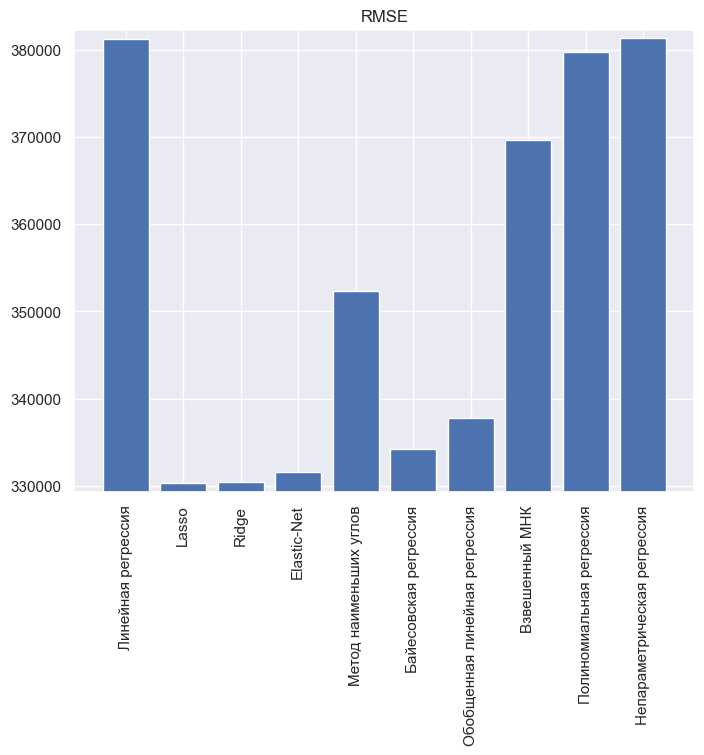

In [62]:
plt.figure(figsize=(8, 6))
plt.title("RMSE")
plt.ylim([min(RMSE.values()) - 1000, max(RMSE.values()) + 1000])
plt.bar(RMSE.keys(), RMSE.values())
plt.xticks(rotation=90)
plt.show()